In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [7]:

# Load the data
data = pd.read_csv('davis.txt', header=None, delimiter=' ')

data.rename(columns={0: 'drug_id', 1: 'protein_id', 2: 'SMILES', 3: 'Protein', 4: 'pKb'}, inplace=True)
data.head()


,drug_id,protein_id,SMILES,Protein,pKb
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,11314340,ABL1(E255K),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
2,11314340,ABL1(F317I),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
3,11314340,ABL1(F317I)p,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
4,11314340,ABL1(F317L),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000


In [8]:
# encoding data

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
encoding_protein = {aa: i+1 for i, aa in enumerate(amino_acids)}
smiles_symbols = '=()CNOF123456'
encoding_smiles = {s: i+1 for i, s in enumerate(smiles_symbols)}

data['enc_protein'] = [np.array([encoding_protein.get(char, 0) for char in data.at[i, 'Protein']]) for i in range(data.index.size)]
# data['enc_protein'] = [np.frombuffer(data.at[i, 'Protein'].encode(), dtype=np.int8) - 64 for i in range(data.index.size)]
data['enc_protein_len'] = [len(data.at[i, 'enc_protein']) for i in range(data.index.size)]

data['enc_smiles'] = [np.array([encoding_smiles.get(char, 0) for char in data.at[i, 'SMILES']]) for i in range(data.index.size)]
# data['enc_smiles'] = [np.frombuffer(data.at[i, 'SMILES'].encode(), dtype=np.int8) - 40 for i in range(data.index.size)]
data['enc_smiles_len'] = [len(data.at[i, 'enc_smiles']) for i in range(data.index.size)]
data.head()

,drug_id,protein_id,SMILES,Protein,pKb,enc_protein,enc_protein_len,enc_smiles,enc_smiles_len
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...",961,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51
1,11314340,ABL1(E255K),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51
2,11314340,ABL1(F317I),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51
3,11314340,ABL1(F317I)p,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51
4,11314340,ABL1(F317L),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51


In [9]:
df1 = data[['enc_protein_len', 'enc_smiles_len']]
print(df1.min(axis='index'))
print(df1.max(axis='index'))

enc_protein_len    244
enc_smiles_len      39
dtype: int64
enc_protein_len    2549
enc_smiles_len       92
dtype: int64


In [10]:
# converting inputs to fixed-length arrays

enc_protein_len_max = 244
enc_smiles_len_max = 39

# enc_protein_len_max = 2549
# enc_smiles_len_max = 92

# truncating input arrays
data['enc_protein_pad'] = [data.at[i, 'enc_protein'][0 : enc_protein_len_max] for i in range(data.index.size)]
data['enc_smiles_pad'] = [data.at[i, 'enc_smiles'][0 : enc_smiles_len_max] for i in range(data.index.size)]

# padding input arrays
# data['enc_protein_pad'] = [np.pad(i, (0, enc_protein_len_max - i.size), 'constant', constant_values=(0, 0)) for i in data['enc_protein']]
# data['enc_smiles_pad'] = [np.pad(i, (0, enc_smiles_len_max - i.size), 'constant', constant_values=(0, 0)) for i in data['enc_smiles']]
data.head()

,drug_id,protein_id,SMILES,Protein,pKb,enc_protein,enc_protein_len,enc_smiles,enc_smiles_len,enc_protein_pad,enc_smiles_pad
0,11314340,AAK1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...",961,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ..."
1,11314340,ABL1(E255K),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ..."
2,11314340,ABL1(F317I),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ..."
3,11314340,ABL1(F317I)p,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ..."
4,11314340,ABL1(F317L),CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...",1167,"[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",51,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ..."


In [35]:
data_to_use = data[['drug_id', 'protein_id', 'enc_protein_pad', 'enc_smiles_pad', 'pKb']]
data_to_use.head()

,drug_id,protein_id,enc_protein_pad,enc_smiles_pad,pKb
0,11314340,AAK1,"[11, 9, 9, 5, 5, 3, 16, 15, 15, 4, 14, 6, 6, 1...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",7.366532
1,11314340,ABL1(E255K),"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",5.000000
2,11314340,ABL1(F317I),"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",5.000000
3,11314340,ABL1(F317I)p,"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",5.000000
4,11314340,ABL1(F317L),"[13, 5, 19, 9, 8, 10, 12, 13, 10, 10, 4, 15, 6...","[4, 4, 8, 1, 4, 9, 4, 1, 4, 2, 4, 1, 4, 4, 9, ...",5.000000


In [39]:
#  Prepare the data

# Simple data augmentation: reversal of each protein sequence
augmented_data = []
for i, row in data.iterrows():
    enc_protein = row['enc_protein_pad'].copy()
    np.flip(enc_protein)
    augmented_data.append([row['drug_id'], row['protein_id'], enc_protein, row['enc_smiles_pad'], row['pKb']])

augmented_df = pd.DataFrame(augmented_data, columns=['drug_id', 'protein_id', 'enc_protein_pad', 'enc_smiles_pad', 'pKb'])
data_to_use = pd.concat([data_to_use, augmented_df], ignore_index=True)

X = np.array(data_to_use[['enc_protein_pad', 'enc_smiles_pad']].apply(lambda x: np.concatenate((x.iloc[0], x.iloc[1]), axis=0), axis=1).tolist())
y = np.array(data_to_use['pKb'].tolist())

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [40]:
# Split data such that each protein has a fixed ratio of entries in both training and testing split

def split_by_protein(data, X, y):
    # Group data by protein
    grouped = data.groupby('protein_id')

    train_indices = []
    test_indices = []

    # Split each group
    for _, group in grouped:
        train_idx, test_idx = train_test_split(group.index, test_size=0.3, random_state=42)
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

    # Create train and test datasets
    train_dataset = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    test_dataset = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_dataset, test_dataset

In [41]:
# Split data that some proteins are entirely new in the testing split

def split_new_proteins(data, X, y):
    # Get unique protein IDs
    unique_proteins = data['protein_id'].unique()

    # Shuffle the protein IDs
    np.random.shuffle(unique_proteins)

    # Split the protein IDs into training and testing sets
    train_proteins = unique_proteins[:int(0.9 * len(unique_proteins))]
    test_proteins = unique_proteins[int(0.9 * len(unique_proteins)):]

    # Get the indices for the training and testing sets
    train_indices = data[data['protein_id'].isin(train_proteins)].index
    test_indices = data[data['protein_id'].isin(test_proteins)].index

    # Create train and test datasets
    train_dataset = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    test_dataset = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_dataset, test_dataset

In [42]:
# Split data such that each drug has a fixed ratio of entries in both training and testing split

def split_by_drug(data, X, y):
    # Group data by drug
    grouped = data.groupby('drug_id')

    train_indices = []
    test_indices = []

    # Split each group
    for _, group in grouped:
        train_idx, test_idx = train_test_split(group.index, test_size=0.3, random_state=42)
        train_indices.extend(train_idx)
        test_indices.extend(test_idx)

    # Create train and test datasets
    train_dataset = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    test_dataset = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_dataset, test_dataset

In [43]:
# Split data that some drugs are entirely new in the testing split

def split_new_drugs(data, X, y):
    # Get unique drug IDs
    unique_drugs = data['drug_id'].unique()

    # Shuffle the drug IDs
    np.random.shuffle(unique_drugs)

    # Split the drug IDs into training and testing sets
    train_drugs = unique_drugs[:int(0.9 * len(unique_drugs))]
    test_drugs = unique_drugs[int(0.9 * len(unique_drugs)):]

    # Get the indices for the training and testing sets
    train_indices = data[data['drug_id'].isin(train_drugs)].index
    test_indices = data[data['drug_id'].isin(test_drugs)].index

    # Create train and test datasets
    train_dataset = torch.utils.data.TensorDataset(X[train_indices], y[train_indices])
    test_dataset = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])
    return train_dataset, test_dataset

In [44]:
# Concordance index

from lifelines.utils import concordance_index

def evaluate_ci(test_targets, test_predictions):
    # Calculate the concordance index
    c_index = concordance_index(test_targets, test_predictions)
    print(f'Concordance Index: {c_index}')

In [45]:
# Mean square error

from sklearn.metrics import mean_squared_error

def evaluate_mse(test_targets, test_predictions):
    # Calculate the mean-square error
    mse = mean_squared_error(test_targets, test_predictions)
    print(f'Mean-Square Error: {mse}')

In [46]:
# Pearson correlation coefficient

from scipy.stats import pearsonr

def evaluate_pearsonr(test_targets, test_predictions):
    # Calculate the Pearson correlation coefficient
    pearson_corr, _ = pearsonr(test_targets, test_predictions)
    print(f'Pearson Correlation Coefficient: {pearson_corr}')

In [47]:
# Area under the precision-recall curve

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import Binarizer

def evaluate_auprc(test_targets, test_predictions):
    # Binarize the targets and predictions
    binarizer = Binarizer(threshold=7.0)
    test_targets_bin = binarizer.fit_transform(np.array(test_targets).reshape(-1, 1)).flatten()
    test_predictions_bin = binarizer.transform(np.array(test_predictions).reshape(-1, 1)).flatten()
    
    precision, recall, _ = precision_recall_curve(test_targets_bin, test_predictions_bin)
    auprc = auc(recall, precision)
    print(f'Area Under the Precision-Recall Curve: {auprc}')

In [53]:
# r_m^2 index

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def evaluate_rm2(test_targets, test_predictions):
    y_obs = np.array(test_targets)
    y_pred = np.array(test_predictions)

    # Calculate r^2
    r2 = r2_score(y_obs, y_pred)

    # Calculate r_0^2 
    numerator = np.sum((test_targets - test_predictions) ** 2, axis=0)
    denominator = np.sum((test_targets) ** 2, axis=0)
    r2_0 = 1 - numerator / denominator

    # Case: r^2 < r_0^2:
    if r2 < r2_0:
        print(f'r^2: {r2}, r_0^2: {r2_0}')
        print('r_m^2 is not defined')
        return

    # Calculate r_m^2
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    print(f'rm2: {rm2}')

In [49]:
# evaluate model on test data

def eval_model(model, test_loader):
    model.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_predictions.extend(outputs.numpy())
            test_targets.extend(targets.numpy())

    test_predictions = np.array(test_predictions).flatten()
    test_targets = np.array(test_targets).flatten()

    evaluate_mse(test_targets, test_predictions)


In [50]:
# Prepare training and testing datasets

train_dataset, test_dataset = split_by_protein(data, X, y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * ((enc_protein_len_max + enc_smiles_len_max) // 8), 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)

        # Add batch normalization layers
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate

# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    eval_model(model, test_loader)

# Evaluating the model
model.eval()
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.numpy())
        test_targets.extend(targets.numpy())

# Convert lists to numpy arrays
test_predictions = np.array(test_predictions).flatten()
test_targets = np.array(test_targets).flatten()

# Evaluate the model using the defined metrics
evaluate_ci(test_targets, test_predictions)
evaluate_mse(test_targets, test_predictions)
evaluate_pearsonr(test_targets, test_predictions)
evaluate_auprc(test_targets, test_predictions)
evaluate_rm2(test_targets, test_predictions)

Epoch 1/2, Loss: 1.6387161337412322
Mean-Square Error: 0.8301137685775757
Epoch 2/2, Loss: 1.370310266338862
Mean-Square Error: 0.893027663230896
Concordance Index: 0.6470164463832453
Mean-Square Error: 0.893027663230896
Pearson Correlation Coefficient: 0.2290417696019228
Area Under the Precision-Recall Curve: 0.122513893895027
r^2: -0.16340970993041992, r_0^2: 0.9709950685501099
r_m^2 is not defined


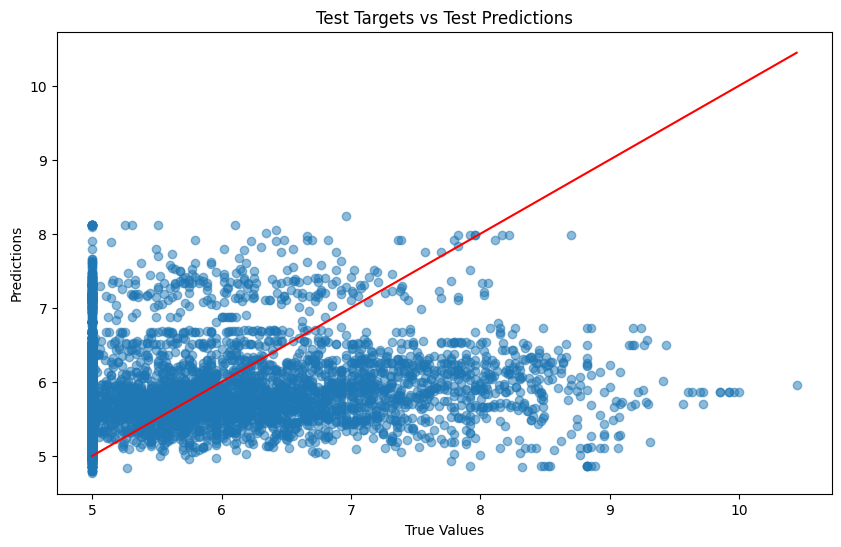

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_targets, test_predictions, alpha=0.5)
plt.plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], color='red')  # Line y=x
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Targets vs Test Predictions')
plt.show()